In [145]:
import numpy as np
from __future__ import print_function
import os
import random
import string
import zipfile
from six.moves import range
from six.moves.urllib.request import urlretrieve

import tensorflow as tf
tf.reset_default_graph()
sess = tf.InteractiveSession()
import matplotlib.pyplot as plt
%matplotlib inline

---
Problem 3
---------

(difficult!)

Write a sequence-to-sequence LSTM which mirrors all the words in a sentence. For example, if your input is:

    the quick brown fox
    
the model should attempt to output:

    eht kciuq nworb xof
    
Refer to the lecture on how to put together a sequence-to-sequence model, as well as [this article](http://arxiv.org/abs/1409.3215) for best practices.

---

In [17]:
## utility functions:

url = 'http://mattmahoney.net/dc/'
first_letter = ord(string.ascii_lowercase[0])


def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)


def read_data(filename):
    with zipfile.ZipFile(filename) as f:
        name = f.namelist()[0]
        data = tf.compat.as_str(f.read(name))
    return data

def char2id(char):
  if char in string.ascii_lowercase:
    return ord(char) - first_letter + 1
  elif char == ' ':
    return 0
  else:
    print('Unexpected character: %s' % char)
    return 0
  
def id2char(dictid):
  if dictid > 0:
    return chr(dictid + first_letter - 1)
  else:
    return ' '

Found and verified text8.zip


In [68]:
def batch_fun(inputs, max_sequence_length=None):
    """
    Args:
        inputs:
            list of sentences (integer lists)
        max_sequence_length:
            integer specifying how large should `max_time` dimension be.
            If None, maximum sequence length would be used
    
    Outputs:
        inputs_time_major:
            input sentences transformed into time-major matrix 
            (shape [max_time, batch_size]) padded with 0s
        sequence_lengths:
            batch-sized list of integers specifying amount of active 
            time steps in each input sequence
    """
    
    sequence_lengths = [len(seq) for seq in inputs]
    batch_size = len(inputs)
    
    if max_sequence_length is None:
        max_sequence_length = max(sequence_lengths)
    
    inputs_batch_major = np.zeros(shape=[batch_size, max_sequence_length], dtype=np.int32) # == PAD
    
    for i, seq in enumerate(inputs):
        for j, element in enumerate(seq):
            inputs_batch_major[i, j] = element

    # [batch_size, max_time] -> [max_time, batch_size]
    inputs_time_major = inputs_batch_major.swapaxes(0, 1)

    return inputs_time_major, sequence_lengths

In [69]:
batch_fun([[1,2,3,5], [3,4,5], [4,6,7]])

(array([[1, 3, 4],
        [2, 4, 6],
        [3, 5, 7],
        [5, 0, 0]], dtype=int32), [4, 3, 3])

In [142]:
text = read_data(filename)
print('Data size %d' % len(text))
text = text.split()
print('Num of words:', len(text))

Data size 100000000
Num of words: 17005207


In [12]:
print(char2id('a'), char2id('z'), char2id(' '), char2id('ï'))
print(id2char(1), id2char(26), id2char(0))

Unexpected character: ï
1 26 0 0
a z  


In [140]:
vocab_size = len(string.ascii_lowercase) + 1 # [a-z] + ' '
input_embedding_size = 60

encoder_hidden_units = 60
decoder_hidden_units = encoder_hidden_units

In [26]:
encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_inputs')
decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets')

In [27]:
decoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_inputs')

In [28]:
embeddings = tf.Variable(tf.random_uniform([vocab_size, input_embedding_size], -1.0, 1.0), dtype=tf.float32)
encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs)
decoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, decoder_inputs)

with tf.variable_scope('cell_def'):
    encoder_cell = tf.contrib.rnn.LSTMCell(encoder_hidden_units)
    
with tf.variable_scope('rnn_def'):
    encoder_outputs, encoder_final_state = tf.nn.dynamic_rnn(
        encoder_cell, encoder_inputs_embedded,
        dtype=tf.float32, time_major=True
    )

del encoder_outputs

In [29]:
decoder_cell = tf.contrib.rnn.LSTMCell(decoder_hidden_units)

decoder_outputs, decoder_final_state = tf.nn.dynamic_rnn(
    decoder_cell, decoder_inputs_embedded,

    initial_state=encoder_final_state,

    dtype=tf.float32, time_major=True, scope="plain_decoder",
)

In [30]:
decoder_logits = tf.contrib.layers.linear(decoder_outputs, vocab_size)
decoder_prediction = tf.argmax(decoder_logits, axis = 2)

In [31]:
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits,
)

loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.AdamOptimizer().minimize(loss)

In [32]:
sess.run(tf.global_variables_initializer())

In [35]:
#### simple test ####

batch_ = [[6], [3, 4], [9, 8, 7]]

batch_, batch_length_ = batch(batch_)
print('batch_encoded:\n' + str(batch_))

din_, dlen_ = batch(np.ones(shape=(3, 1), dtype=np.int32),
                            max_sequence_length=4)
print('decoder inputs:\n' + str(din_))

pred_ = sess.run(decoder_prediction,
    feed_dict={
        encoder_inputs: batch_,
        decoder_inputs: din_,
    })
print('decoder predictions:\n' + str(pred_))

batch_encoded:
[[6 3 9]
 [0 4 8]
 [0 0 7]]
decoder inputs:
[[1 1 1]
 [0 0 0]
 [0 0 0]
 [0 0 0]]
decoder predictions:
[[ 9 16 21]
 [ 9  9 21]
 [ 9 11 11]
 [25 11 11]]


In [143]:
num_words = len(text)

def create_batch(batch_size):
    """ Generates batches of words in sequence;
        vocabulary in [vocab_lower, vocab_upper]
    """
    while (create_batch.count+batch_size)<=num_words:
        tmp = text[create_batch.count:create_batch.count+batch_size]
        create_batch.count+=batch_size
#         print(create_batch.count)
#         print('len(tmp):', len(tmp))
        yield [[char2id(j) for j in i] for i in tmp]

In [144]:
batch_size = 20
def next_feed():
    batch_ = next(create_batch(batch_size))
    
    encoder_inputs_, _ = batch_fun(batch_)
    decoder_targets_, _ = batch_fun(
        [sequence[::-1] for sequence in batch_]
    )
    decoder_inputs_, _ = batch_fun(batch_)
    return {
        encoder_inputs: encoder_inputs_,
        decoder_inputs: decoder_inputs_,
        decoder_targets: decoder_targets_,
    }

In [131]:
loss_track = []

In [139]:
max_batches = 3001
batches_in_epoch = 1000
create_batch.count = 0

try:
    for batch in range(max_batches):
        fd = next_feed()
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)

        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(decoder_prediction, fd)
            for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 2:
                    break
            print()
except KeyboardInterrupt:
    print('training interrupted')

batch 0
  minibatch loss: 3.1552977561950684
  sample 1:
    input     > [ 1 14  1 18  3  8  9 19 13  0]
    predicted > [ 9  9  9  9  9  0 18 13 12 21]
  sample 2:
    input     > [15 18  9  7  9 14  1 20  5  4]
    predicted > [20 13 13 17 18 13 13 13 17 17]
  sample 3:
    input     > [ 1 19  0  0  0  0  0  0  0  0]
    predicted > [ 9  9  0  0  0  0  0  0 25 25]

batch 1000
  minibatch loss: 0.3808487057685852
  sample 1:
    input     > [23  9 20  8  0  0  0  0  0  0  0]
    predicted > [ 8 20  9 23  0  0  0  0  0  0  0]
  sample 2:
    input     > [20  8  5  0  0  0  0  0  0  0  0]
    predicted > [ 5  8 20  0  0  0  0  0  0  0  0]
  sample 3:
    input     > [ 1  5  7  9 19  0  0  0  0  0  0]
    predicted > [19  5  9  5  7  0  0  0  0  0  0]

batch 2000
  minibatch loss: 0.1958051472902298
  sample 1:
    input     > [16 18  5 19  5 14 20]
    predicted > [20 14  5 19  5 18 16]
  sample 2:
    input     > [ 2  5 19 20  0  0  0]
    predicted > [20 19  5  2  0  0  0]
  sample 3:

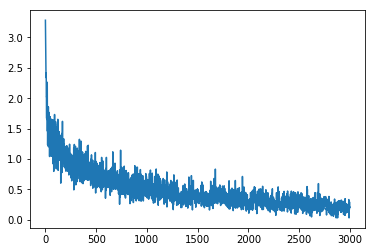

In [146]:
plt.plot(loss_track)